# Regresja liniowa w Keras – rozwiązanie zadania


## Część 1: Budowa modelu

Model ma mieć **jeden neuron** (`Dense(1)`) i działa jak klasyczna regresja liniowa:
gdzie `w` to waga (nachylenie prostej), a `b` to bias (wyraz wolny / przesunięcie).


In [7]:
# 1) Importy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# (Opcjonalnie) dla powtarzalności wyników
np.random.seed(42)
tf.random.set_seed(42)

print("TF version:", tf.__version__)


TF version: 2.19.0


In [8]:
# 2) Dane
# Metraż (m2)
X = np.array([25, 30, 45, 50, 65, 80, 95, 110]).reshape(-1, 1)

# Cena (tys. PLN)
y = np.array([180, 210, 310, 350, 430, 520, 610, 700])

X, y


(array([[ 25],
        [ 30],
        [ 45],
        [ 50],
        [ 65],
        [ 80],
        [ 95],
        [110]]),
 array([180, 210, 310, 350, 430, 520, 610, 700]))

In [9]:
# 3) Budowa modelu
model = keras.Sequential([
    layers.Dense(1, input_shape=(1,))  # 1 wejście (metraż), 1 wyjście (cena)
])

# 4) Kompilacja: SGD + learning_rate=0.0001, loss=MSE
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt, loss="mse")

# Podsumowanie modelu (odpowiada na pytanie o liczbę parametrów)
model.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)


 • Ile parametrów ma ten model?<br>
  -> Dla Dense(1) z 1 wejściem: ma 2 parametry: 1 waga (weight) + 1 bias.

 • Co oznacza waga (weight) w kontekście tego problemu?<br>
  -> Weight mówi, o ile (w tys. PLN) zmienia się przewidywana cena, gdy metraż zwiększa się o 1 m2.

 • Co oznacza bias w kontekście tego problemu?<br>
  -> Bias to wyraz wolny – cena bazowa, gdy x=0 (punkt przecięcia z osią Y). W praktyce „przesuwa” prostą w górę/dół.

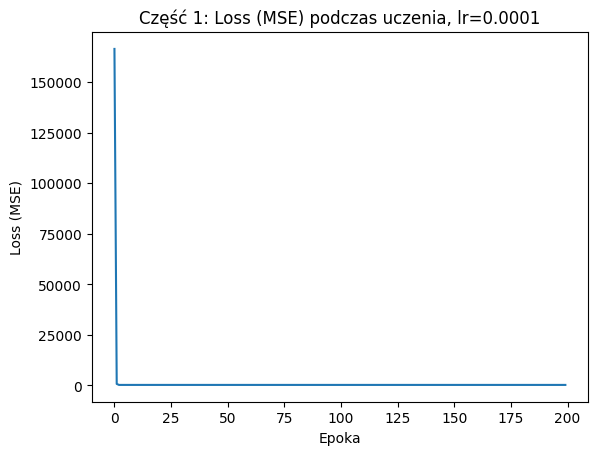

np.float32(456.96832)

In [10]:
# 5) Trening przez 200 epok + zapis historii
history = model.fit(X, y, epochs=200, verbose=0)

# Wykres loss
plt.figure()
plt.plot(history.history["loss"])
plt.title("Część 1: Loss (MSE) podczas uczenia, lr=0.0001")
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.show()

# 6) Predykcja ceny dla 70 m2
pred_70 = model.predict(np.array([[70.0]]), verbose=0)[0, 0]
pred_70


## Część 2: Eksperyment z learning rate

Trenujemy **ten sam typ modelu** dla trzech wartości `learning_rate` i porównujemy przebieg `loss`.


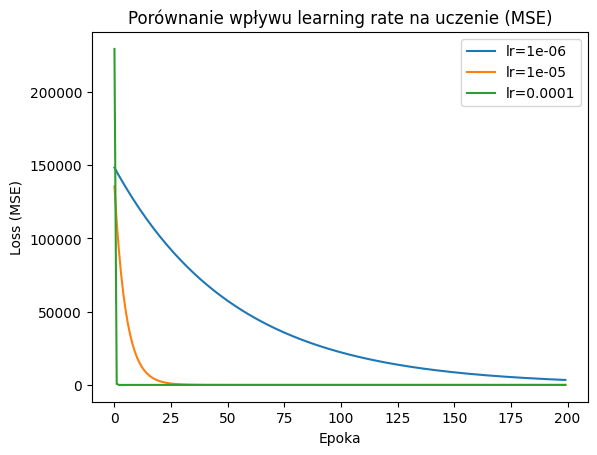

[(1e-06, 3598.791748046875, None),
 (1e-05, 220.27584838867188, 33),
 (0.0001, 217.68370056152344, 3)]

In [11]:
def build_and_train(lr: float, epochs: int = 200):

    m = keras.Sequential([layers.Dense(1, input_shape=(1,))])
    m.compile(optimizer=keras.optimizers.SGD(learning_rate=lr), loss="mse")
    h = m.fit(X, y, epochs=epochs, verbose=0)
    return m, h

lrs = [0.000001, 0.00001, 0.0001]
histories = {}
models = {}

for lr in lrs:
    m, h = build_and_train(lr, epochs=200)
    models[lr] = m
    histories[lr] = h

# Wykres porównawczy
plt.figure()
for lr in lrs:
    plt.plot(histories[lr].history["loss"], label=f"lr={lr:g}")
plt.title("Porównanie wpływu learning rate na uczenie (MSE)")
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


threshold = 500

def epochs_to_threshold(losses, thr):
    for i, v in enumerate(losses, start=1):
        if v <= thr:
            return i
    return None

results = []
for lr in lrs:
    losses = histories[lr].history["loss"]
    e = epochs_to_threshold(losses, threshold)
    results.append((lr, losses[-1], e))

results


## Wnioski


- **Najlepszy learning rate** zwykle jest ten, który najszybciej i stabilnie obniża `loss` do niskich wartości w zadanej liczbie epok (bez oscylacji / rozbiegania).
- **Gdy `lr` jest za mały**, spadek `loss` jest bardzo wolny – model uczy się „mikrokrokami” i może nie zdążyć dobrze dopasować się w 200 epok.
- **Gdy `lr` jest większy (ale nadal rozsądny)**, `loss` spada szybciej, bo kroki optymalizacji są większe.




In [12]:
# Automatyczna interpretacja wyników (na podstawie 'results' z poprzedniej komórki)
for lr, final_loss, e in results:
    print(f"lr={lr:g} -> final loss={final_loss:.2f} | epoki do zejścia poniżej progu {threshold}: {e}")

# Najlepszy lr wg najmniejszego final loss
best_lr = min(results, key=lambda t: t[1])[0]
print("\nNajmniejszy final loss uzyskano dla:", best_lr)


lr=1e-06 -> final loss=3598.79 | epoki do zejścia poniżej progu 500: None
lr=1e-05 -> final loss=220.28 | epoki do zejścia poniżej progu 500: 33
lr=0.0001 -> final loss=217.68 | epoki do zejścia poniżej progu 500: 3

Najmniejszy final loss uzyskano dla: 0.0001
